# GAN
In this notebook, we are going to be focusing on the Image to Image generative adversarial network in the gan module in PAI-Utils.

## Setup
First, we need to import packages and get the Cityscapes dataset.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image, display

from paiutils import image
from paiutils import util_funcs
from paiutils import neural_network as nn
from paiutils import gan

# see if using GPU and if so enable memory growth
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Get Cityscapes Dataset
The dataset used here can be downloaded from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/). It is a modified version, which is quicker to download for a demo. The real dataset can be downloaded [here](https://www.cityscapes-dataset.com/)

In [2]:
# Get dataset
dataset_path = 'cityscapes'
dataset = util_funcs.load_directory_datasets(dataset_path, image.load)

dataset2 = {}
for key in dataset:
    dataset2[key] = ([], [])
    for x in dataset[key]:
        real_x = image.shrink_sides(x, rs=256)
        seg_x = image.shrink_sides(x, ls=256)

        real_x = image.resize(real_x, (128, 128))
        seg_x = image.resize(seg_x, (128, 128))
        
        real_x = image.normalize(real_x)
        seg_x = image.normalize(seg_x)

        #dataset2[key][0].append(real_x)
        #dataset2[key][1].append(seg_x)
        dataset2[key][1].append(real_x)
        dataset2[key][0].append(seg_x)
dataset = dataset2
        
data = {
    'train_x': np.array(dataset['train'][0]), 
    'train_y': np.array(dataset['train'][1]),
    'validation_x': (np.array(dataset['val'][0]), np.array(dataset['val'][1])), 
    'validation_y': np.ones((len(dataset['val'][0]), 16, 16, 1))
}
del dataset

print(data['train_x'].shape, data['train_y'].shape)
shape = data['train_x'].shape[1:]

(2975, 128, 128, 3) (2975, 128, 128, 3)


## Create the Model
We will need to make a generative network that will create images and a discriminator network that will be able to determine if an image is real or fake.

In [3]:
x0 = keras.layers.Input(shape=shape)
x1 = nn.conv2d(64, 5, 2)(x0)
x2 = nn.conv2d(128, 3, 2)(x1)
x3 = nn.conv2d(256, 3, 2)(x2)
x4 = nn.conv2d(512, 3, 2)(x3)
x5 = nn.conv2d(512, 3, 2)(x4)
x6 = nn.conv2d(512, 3, 2)(x5)
x = nn.conv2d(512, 3, 2, transpose=True)(x6)
x = keras.layers.Concatenate()([x, x5])
x = nn.conv2d(512, 3, 2, transpose=True)(x)
x = keras.layers.Concatenate()([x, x4])
x = nn.conv2d(512, 3, 2, transpose=True)(x)
x = keras.layers.Concatenate()([x, x3])
x = nn.conv2d(256, 3, 2, transpose=True)(x)
x = keras.layers.Concatenate()([x, x2])
x = nn.conv2d(128, 3, 2, transpose=True)(x)
x = keras.layers.Concatenate()([x, x1])
x = nn.conv2d(64, 3, 2, transpose=True)(x)
x = keras.layers.Concatenate()([x, x0])
x = nn.conv2d(64, 5)(x)
output = nn.conv2d(3, 5, 1, activation='tanh',
                   batch_norm=False)(x)
gen_model = keras.Model(inputs=x0, outputs=output)
gen_model.compile(optimizer=keras.optimizers.Adam(.0003, beta_1=.5),
                  loss='mse')
gen_model.summary()


def conv2d(filters, kernel_size, strides, batch_norm=True):
    conv = nn.conv2d(filters, kernel_size=kernel_size,
                     strides=strides, batch_norm=batch_norm,
                     activation=None)
    act = keras.layers.LeakyReLU(alpha=0.2)
    def layer(x):
        x = conv(x)
        x = act(x)
        return x
    return layer

x0_1 = keras.layers.Input(shape=shape, name='x')
x0_2 = keras.layers.Input(shape=shape, name='y')
x_1 = conv2d(64, 5, 2, batch_norm=False)(x0_1)
x_2 = conv2d(64, 5, 2, batch_norm=False)(x0_2)
x_1 = conv2d(128, 3, 2)(x_1)
x_2 = conv2d(128, 3, 2)(x_2)
x = keras.layers.Concatenate()([x_1, x_2])
x = keras.layers.Dropout(.4)(x)
x = conv2d(512, 3, 2)(x)
x = conv2d(512, 3, 1)(x)
# The GAN Trainer will apply a sigmoid to this output
output = nn.conv2d(1, 3, 1, activation=None, batch_norm=False)(x)
dis_model = keras.Model(inputs=[x0_1, x0_2], outputs=output)
dis_model.compile(optimizer=keras.optimizers.Adam(.0002, beta_1=.5),
                  loss='binary_crossentropy')
dis_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  73856       batch_normalization[0][0]        
_______________________________________________________________________________________

## Train the Model
We can now use the GANITrainer to train the generative and discriminative models on the dataset.

In [4]:
trainer = gan.GANITrainer(
    gen_model, dis_model, data,
    idt_loss_coef=100,
)
trainer.train(100, batch_size=32)
path = trainer.save('')

Epoch 1/100
93/93 [==============================] - 22s 237ms/step - gen_loss: 14.8014 - adversarial_loss: 1.1698 - identity_loss: 0.1363 - discriminator_loss: 0.9933 - dis_fake_input_loss: 0.5083 - dis_real_input_loss: 0.4850 - val_loss: 0.1525
Epoch 2/100
93/93 [==============================] - 20s 218ms/step - gen_loss: 9.8224 - adversarial_loss: 1.6257 - identity_loss: 0.0820 - discriminator_loss: 0.7151 - dis_fake_input_loss: 0.3594 - dis_real_input_loss: 0.3557 - val_loss: 4.9603
Epoch 3/100
93/93 [==============================] - 20s 216ms/step - gen_loss: 9.6881 - adversarial_loss: 1.4968 - identity_loss: 0.0819 - discriminator_loss: 0.8537 - dis_fake_input_loss: 0.4350 - dis_real_input_loss: 0.4187 - val_loss: 9.2957
Epoch 4/100
93/93 [==============================] - 20s 215ms/step - gen_loss: 9.1672 - adversarial_loss: 1.3358 - identity_loss: 0.0783 - discriminator_loss: 0.9787 - dis_fake_input_loss: 0.4922 - dis_real_input_loss: 0.4865 - val_loss: 8.3241
Epoch 5/100
93/

93/93 [==============================] - 20s 216ms/step - gen_loss: 1.7464 - adversarial_loss: 0.7402 - identity_loss: 0.0101 - discriminator_loss: 1.3690 - dis_fake_input_loss: 0.6830 - dis_real_input_loss: 0.6860 - val_loss: 3.0019
Epoch 66/100
93/93 [==============================] - 20s 216ms/step - gen_loss: 1.7448 - adversarial_loss: 0.7362 - identity_loss: 0.0101 - discriminator_loss: 1.3559 - dis_fake_input_loss: 0.6763 - dis_real_input_loss: 0.6796 - val_loss: 6.5079
Epoch 67/100
93/93 [==============================] - 20s 216ms/step - gen_loss: 1.7363 - adversarial_loss: 0.7383 - identity_loss: 0.0100 - discriminator_loss: 1.3563 - dis_fake_input_loss: 0.6777 - dis_real_input_loss: 0.6786 - val_loss: 8.8556
Epoch 68/100
93/93 [==============================] - 20s 216ms/step - gen_loss: 1.7154 - adversarial_loss: 0.7432 - identity_loss: 0.0097 - discriminator_loss: 1.3581 - dis_fake_input_loss: 0.6775 - dis_real_input_loss: 0.6806 - val_loss: 2.5916
Epoch 69/100
93/93 [=====

## Evaluate the Discriminator
Before testing the generator, we can evaluate the discriminator by getting losses for the validation data.

In [5]:
print(trainer.eval(batch_size=100, train_data=False))

Validation Data Evaluation: 
5/5 [==============================] - 0s 33ms/step - loss: 9.7717
{'Validation': 9.771651268005371}


## Test the Generator
The model is now trained and saved, so we can test the generative model by using the GANPredictor to create a list of comparisions.

#### Load Generator

In [6]:
# path = 'trained_model3'
generator = gan.GANIPredictor(path)
discriminator = gan.GANIPredictor(path, uses_generator=False)

#### Display List of Comparisions
We will display the real segemented image on the left, the real image in the middle, and the predicted image on the right. We will also display the discriminator's patches on the far right.

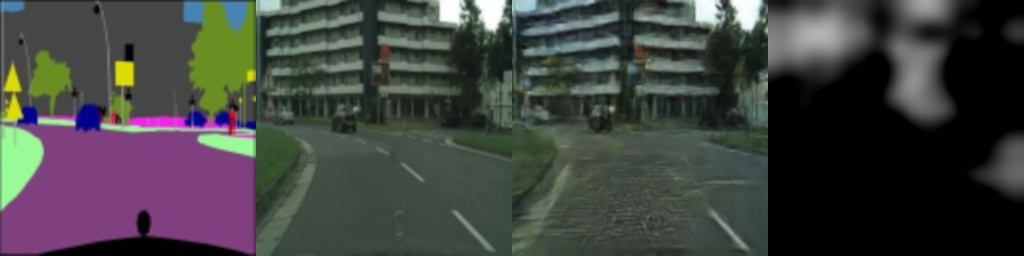

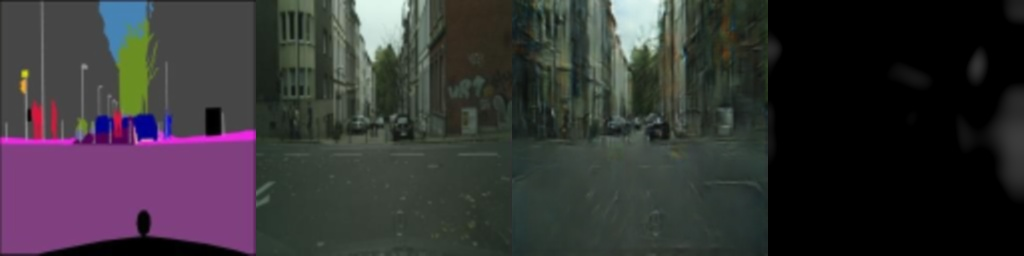

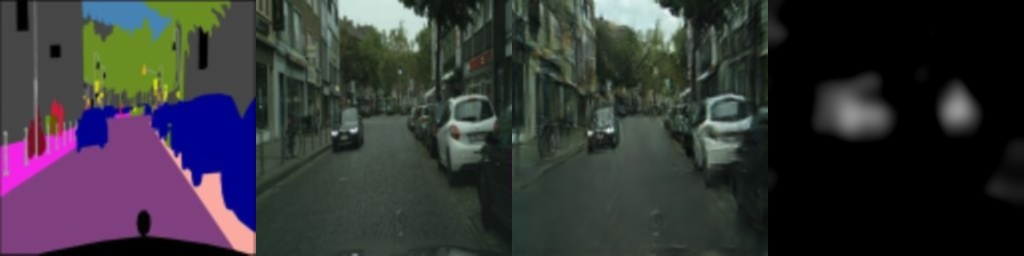

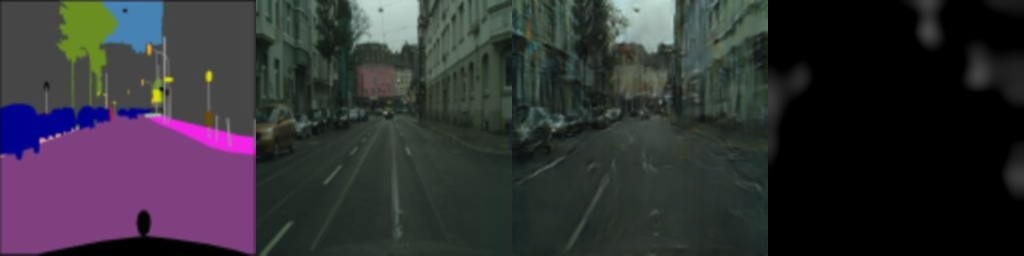

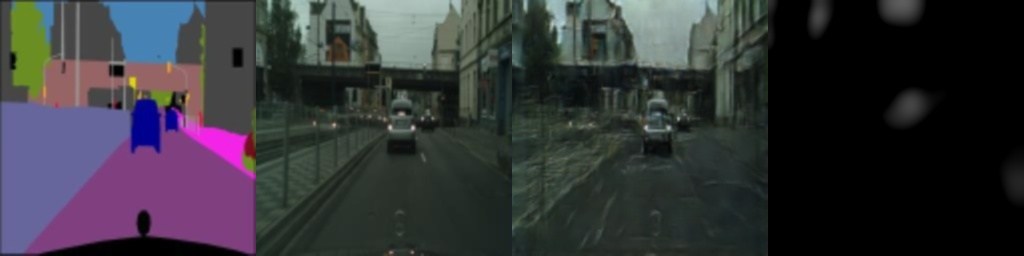

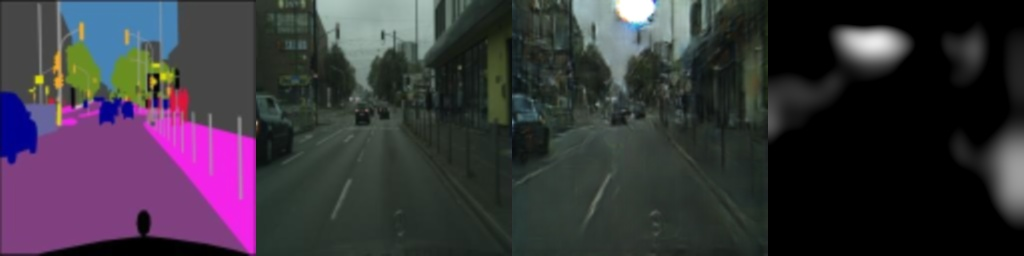

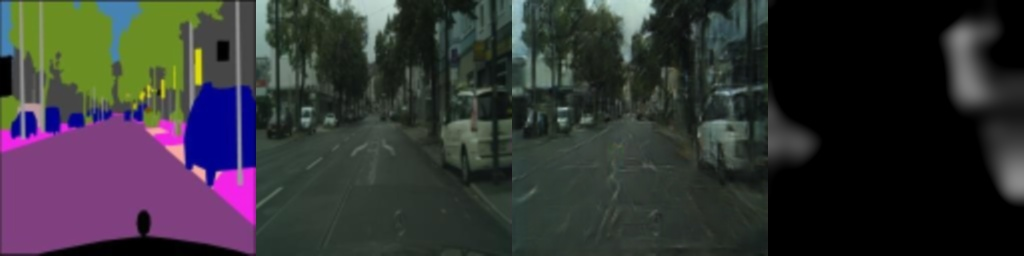

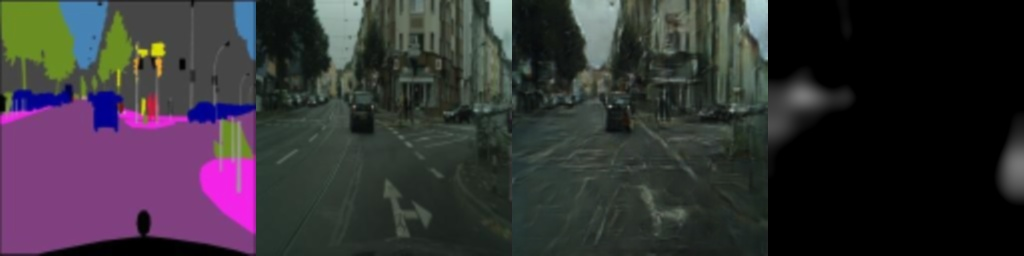

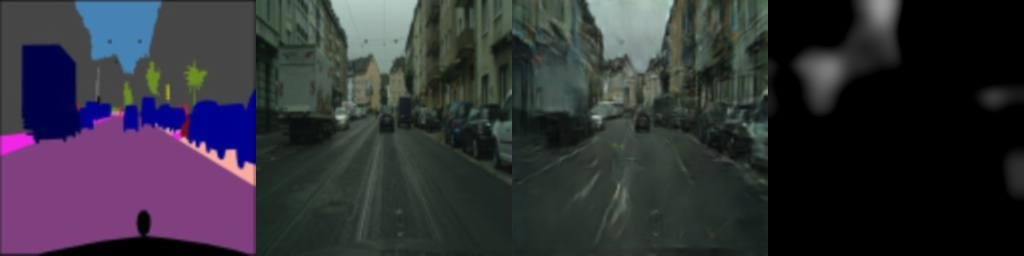

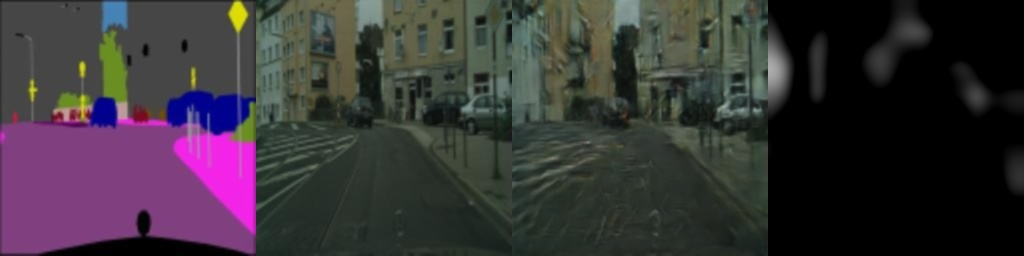

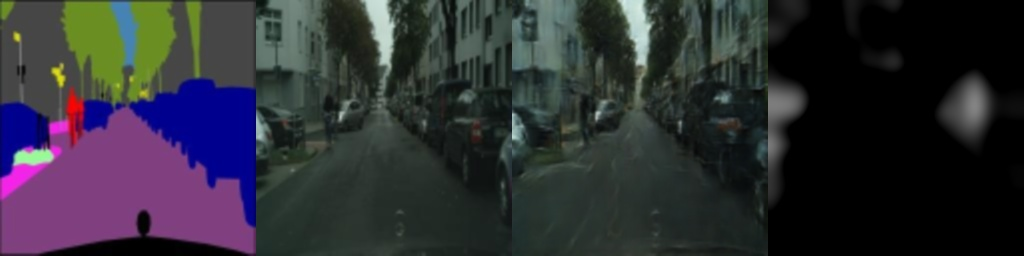

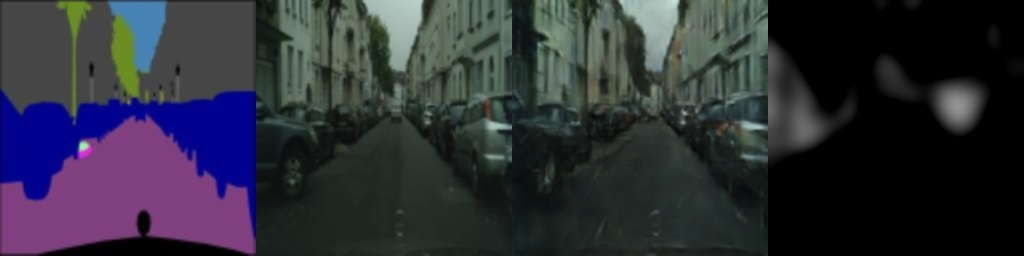

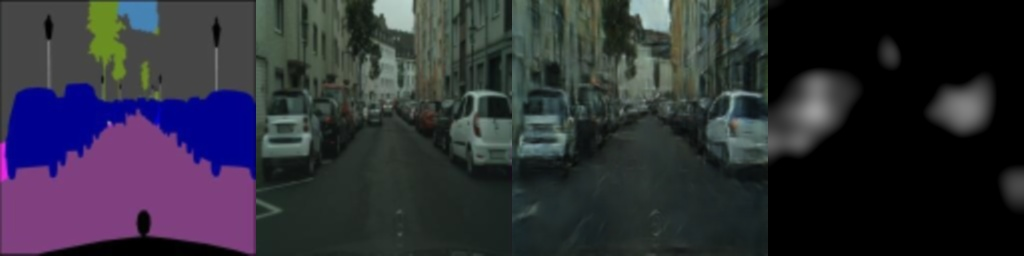

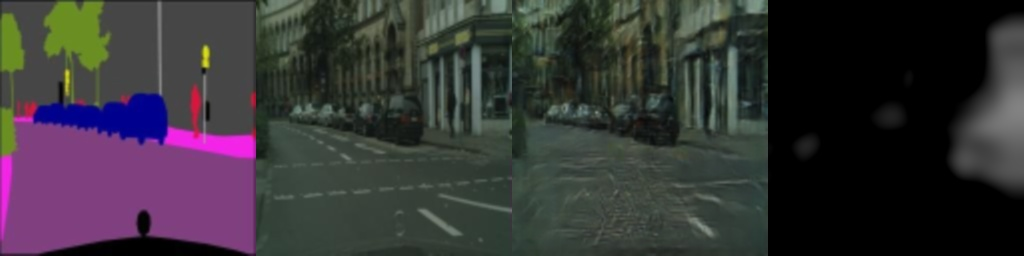

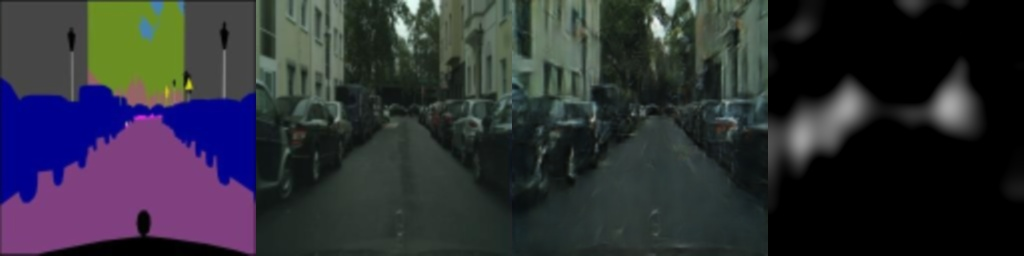

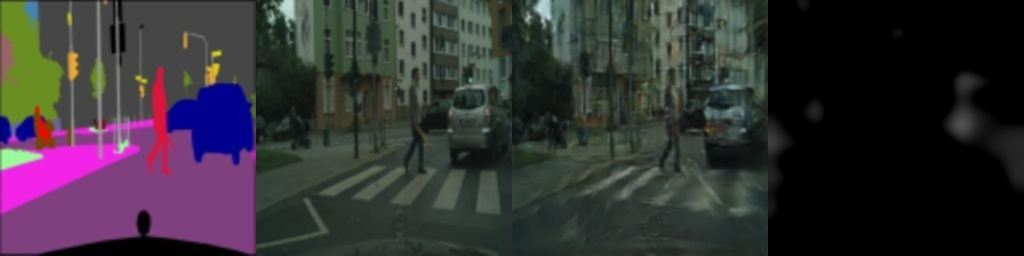

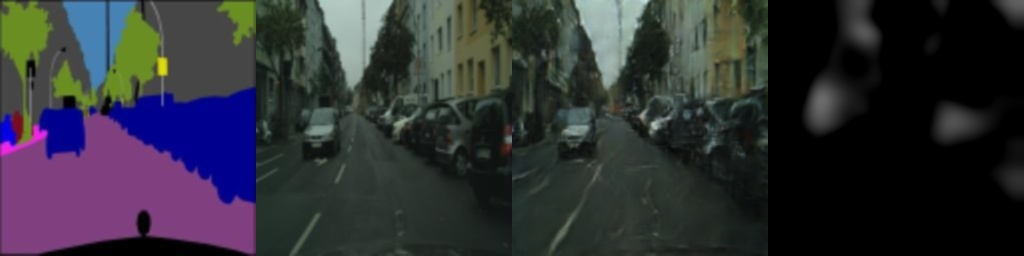

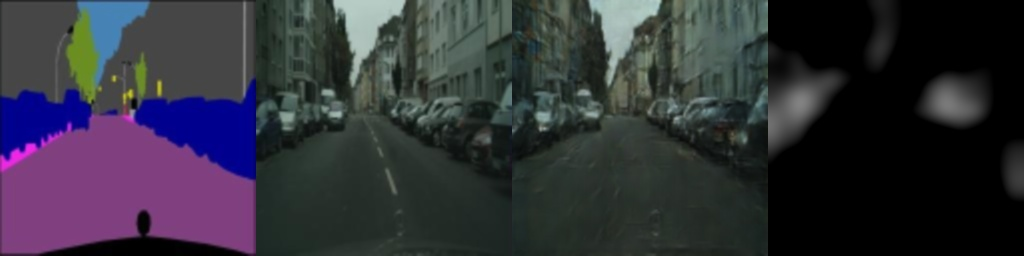

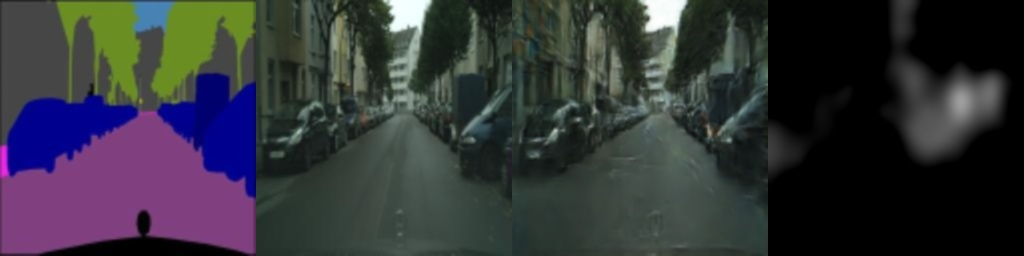

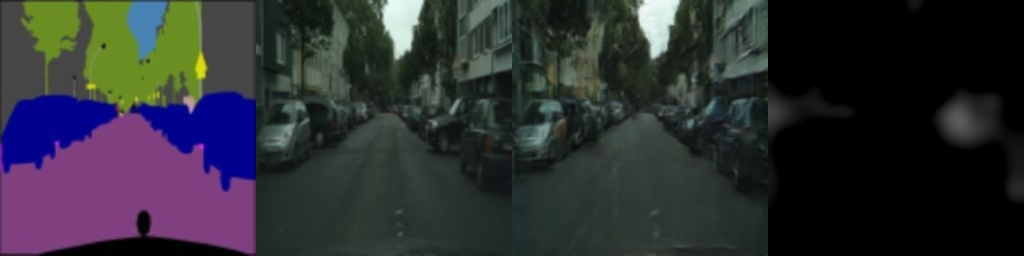

In [7]:
%matplotlib inline
for ndx in range(20):
    #x = data['validation_x'][0][ndx]
    #y = data['validation_x'][1][ndx]
    x = data['train_x'][ndx]
    y = data['train_y'][ndx]
    
    pred = generator.predict(x)
    dis = discriminator.predict({'x': x, 'y': pred}) * 255
    dis = dis[:,:,[0,0,0]]
    pred = image.denormalize(pred)

    
    x = image.denormalize(x)
    y = image.denormalize(y)
    img = np.hstack([
        image.pyr(x, 1), image.pyr(y, 1), image.pyr(pred, 1), image.pyr(dis, 4)
    ])
    ret = image.cv2.imencode('.jpg', img)[1]
    display(Image(data=ret))

The generator does output some reasonable images, besides the one with the big white spot. If we were to have used the validation data instead, the results would have been much worse.